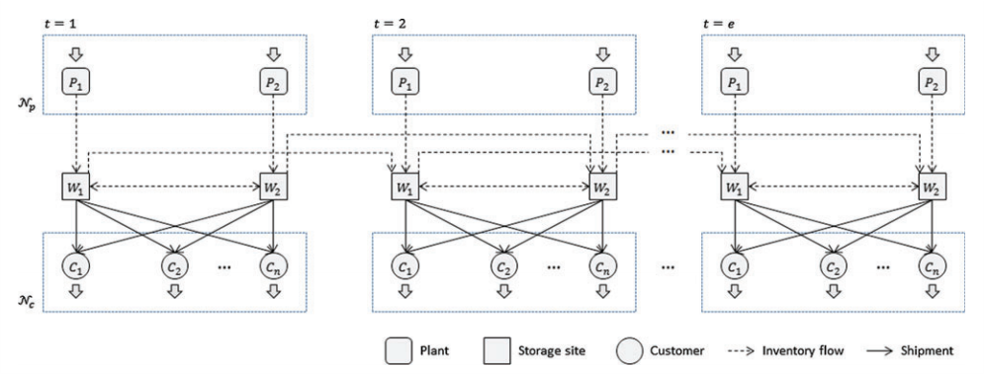

In [34]:
import pandas as pd
from pulp import *
import numpy as np

In [341]:
customer_data = [
    (70, 0, 90, 80, 60, 80, 100, 90, 60, 40), # customer 1
    (100, 70, 30, 60, 40, 20, 80, 60, 50, 90), # customer 2
    (50, 40, 0, 50, 80, 40, 90, 40, 80, 100), # customer 3
]
plant_capacity = [100, 100]
fixed_cost = [100, 100]
variable_cost = [1, 1]
warehouse_capacity = [100, 100]
holding_cost = [1, 1]
wc_shipping_data = [ # from warehouse w to customer c
    (5, 4, 1), # warehouse 1
    (1, 4, 5) # warehouse 2
]
ww_shipping_data = [ # warehouse to warehouse
    (0, 1), # warehouse 1
    (1, 0) # warehouse 2
]
initial_inventory = [0, 0]
maximum_lateness = 2

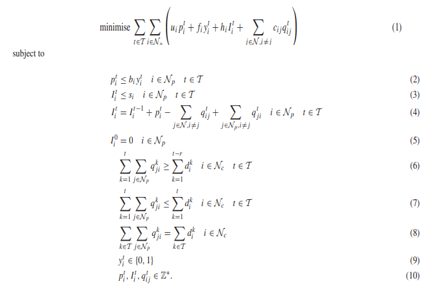

In [347]:
def solve_LP(customer_data, 
             plant_capacity, 
             warehouse_capacity, 
             fixed_cost, 
             variable_cost, 
             holding_cost, 
             wc_shipping_data, 
             ww_shipping_data, 
             initial_inventory, 
             maximum_lateness):
    # Define LP Problem
    model = LpProblem('Dynamic_LP', LpMinimize)

    p, y, i, qc, qw = {}, {}, {}, {}, {}
    time_periods = len(customer_data[0])

    # Create variables for p & y
    for time in range(1, time_periods+1):
        for plant_id in range(1, len(plant_capacity)+1):
            suffix = '_%i_%i' % (time, plant_id)
            p[time, plant_id] = LpVariable(f"p{suffix}", 0)
            y[time, plant_id] = LpVariable(f"y{suffix}", cat='Binary')

    # Create variables for i
    for time in range(time_periods+1):
        for warehouse_id in range(1, len(warehouse_capacity)+1):
            suffix = '_%i_%i' % (time, warehouse_id)
            i[time, warehouse_id] = LpVariable(f"i{suffix}", 0)

    # Create variables for qc and qw
    for time in range(1, time_periods+1):
        for warehouse_id in range(1, len(warehouse_capacity)+1):
            for customer_id in range(1, len(customer_data)+1):
                suffix = '_%i_%i_%i' % (time, warehouse_id, customer_id)
                qc[time, warehouse_id, customer_id] = LpVariable(f"qc{suffix}", 0)

    for time in range(1, time_periods+1):
        for warehouse_id_give in range(1, len(warehouse_capacity)+1):
            for warehouse_id_receive in range(1, len(warehouse_capacity)+1):
                if warehouse_id_give != warehouse_id_receive:
                    suffix = '_%i_%i_%i' % (time, warehouse_id_give, warehouse_id_receive)
                    qw[time, warehouse_id_give, warehouse_id_receive] = LpVariable(f"qw{suffix}", 0)

    # Declare demand coefficients
    d = {}
    for customer_id, customer in enumerate(customer_data):
        for time in range(len(customer)):
            d[time+1, customer_id+1] = customer[time]

    # Declare shipping costs coefficients
    sc, sw = {}, {}
    for warehouse_id, shipping in enumerate(wc_shipping_data):
        for customer_id in range(len(shipping)):
            sc[warehouse_id+1, customer_id+1] = shipping[customer_id]
    for warehouse_id_give, shipping in enumerate(ww_shipping_data):
        for warehouse_id_receive in range(len(shipping)):
            sw[warehouse_id_give+1, warehouse_id_receive+1] = shipping[warehouse_id_receive]

    # Declare plant and warehouse capacity coefficients
    pc, wc = {}, {}
    for plant_id in range(len(plant_capacity)):
        pc[plant_id+1] = plant_capacity[plant_id]
    for warehouse_id in range(len(warehouse_capacity)):
        wc[warehouse_id+1] = warehouse_capacity[warehouse_id]

    # Create inventory-balance constraints
    for init in range(len(initial_inventory)):
        model += i[0, init+1] == initial_inventory[init]

    warehouse_sequence = list(range(1, len(warehouse_capacity)+1))
    for plant_id in range(1, len(plant_capacity)+1):
        for time in range(1, time_periods+1):
            model += i[time, plant_id] == \
            i[time-1, plant_id] + \
            p[time, plant_id] - \
            sum([qc[time, plant_id, customer_id] for customer_id in range(1, len(customer_data)+1)]) + \
            sum([qw[time, warehouse_id, plant_id] 
                 for index, warehouse_id in enumerate(warehouse_sequence) 
                 if warehouse_sequence[index] != plant_id]) - \
            sum([qw[time, plant_id, warehouse_id] 
                 for index, warehouse_id in enumerate(warehouse_sequence) 
                 if warehouse_sequence[index] != plant_id])

    # Create plant and warehouse capacity constraints
    for plant_id in range(1, len(plant_capacity)+1):
        for time in range(1, time_periods+1):
            model += p[time, plant_id] <= pc[plant_id] * y[time, plant_id]
    for warehouse_id in range(1, len(warehouse_capacity)+1):
        for time in range(1, time_periods+1):
            model += i[time, warehouse_id] <= wc[warehouse_id]

    # Create demand constraints
    for customer_id in range(1, len(customer_data)+1):
        for deadline in range(1, time_periods-maximum_lateness+1):
            supply = 0
            for plant_id in range(1, len(plant_capacity)+1):
                supply += sum([qc[time, plant_id, customer_id] for time in range(1, deadline+maximum_lateness+1)])
            model += supply >= sum([d[time, customer_id] for time in range(1, deadline+1)])

    for customer_id in range(1, len(customer_data)+1):
        for deadline in range(1, time_periods+1):
            supply = 0
            for plant_id in range(1, len(plant_capacity)+1):
                supply += sum([qc[time, plant_id, customer_id] for time in range(1, deadline+1)])
            model += supply <= sum([d[time, customer_id] for time in range(1, deadline+1)])

    model += lpSum(qc) == lpSum(d)

    # Define objective function
    total_variable_cost = 0
    for plant_id in range(1, len(plant_capacity)+1):
        total_variable_cost += sum([p[time, plant_id] for time in range(1, time_periods+1)]) * variable_cost[plant_id-1]

    total_fixed_cost = 0
    for plant_id in range(1, len(plant_capacity)+1):
        total_fixed_cost += sum([y[time, plant_id] for time in range(1, time_periods+1)]) * fixed_cost[plant_id-1]

    total_holding_cost = 0
    for warehouse_id in range(1, len(warehouse_capacity)+1):
        total_holding_cost += sum([i[time, warehouse_id] for time in range(1, time_periods+1)]) * holding_cost[plant_id-1]

    total_transportation_cost = 0
    plant_sequence = list(range(1, len(plant_capacity)+1))
    for customer_id in range(1, len(customer_data)+1):
        for plant_id in range(1, len(plant_capacity)+1):
            total_transportation_cost += \
            sum([qc[time, plant_id, customer_id] 
                 for time in range(1, time_periods+1)]) * sc[plant_id, customer_id]

    for plant_id_give in range(1, len(plant_capacity)+1):
        for plant_id_receive in range(1, len(plant_capacity)+1):
            if plant_id_receive != plant_id_give:
                total_transportation_cost += \
                sum([qw[time, plant_id_give, plant_id_receive] 
                     for time in range(1, time_periods+1)]) * sw[plant_id_give, plant_id_receive]

    model += total_variable_cost + total_fixed_cost + total_holding_cost + total_transportation_cost, 'Objective'

    # Solve LP
    model.solve()

    # Print output
    print('Status', LpStatus[model.status])
    print('Objective', model.objective.value())
    for v in model.variables():
        print(v, '=', v.varValue)

    # pd.DataFrame([{'var':name, 'shadow price':c.pi, 'slack':c.slack} for name, c in model.constraints.items()])


In [348]:
customer_data = [
    (70, 0, 90, 80, 60, 80, 100, 90, 60, 40), # customer 1
    (100, 70, 30, 60, 40, 20, 80, 60, 50, 90), # customer 2
    (50, 40, 0, 50, 80, 40, 90, 40, 80, 100), # customer 3
]
plant_capacity = [100, 100]
fixed_cost = [100, 100]
variable_cost = [1, 1]
warehouse_capacity = [100, 100]
holding_cost = [1, 1]
wc_shipping_data = [ # from warehouse w to customer c
    (5, 4, 1), # warehouse 1
    (1, 4, 5) # warehouse 2
]
ww_shipping_data = [ # warehouse to warehouse
    (0, 1), # warehouse 1
    (1, 0) # warehouse 2
]
initial_inventory = [0, 0]
maximum_lateness = 2

solve_LP(customer_data=customer_data, 
         plant_capacity=plant_capacity, 
         warehouse_capacity=warehouse_capacity, 
         fixed_cost=fixed_cost, 
         variable_cost=variable_cost, 
         holding_cost=holding_cost, 
         wc_shipping_data=wc_shipping_data, 
         ww_shipping_data=ww_shipping_data, 
         initial_inventory=initial_inventory, 
         maximum_lateness=maximum_lateness)

Status Optimal
Objective 7540.0
i_0_1 = 0.0
i_0_2 = 0.0
i_10_1 = 0.0
i_10_2 = 0.0
i_1_1 = 0.0
i_1_2 = 0.0
i_2_1 = 0.0
i_2_2 = 0.0
i_3_1 = 0.0
i_3_2 = 0.0
i_4_1 = 0.0
i_4_2 = 0.0
i_5_1 = 0.0
i_5_2 = 20.0
i_6_1 = 40.0
i_6_2 = 40.0
i_7_1 = 10.0
i_7_2 = 0.0
i_8_1 = 10.0
i_8_2 = 10.0
i_9_1 = 30.0
i_9_2 = 0.0
p_10_1 = 100.0
p_10_2 = 100.0
p_1_1 = 70.0
p_1_2 = 70.0
p_2_1 = 100.0
p_2_2 = 0.0
p_3_1 = 100.0
p_3_2 = 100.0
p_4_1 = 100.0
p_4_2 = 100.0
p_5_1 = 100.0
p_5_2 = 100.0
p_6_1 = 100.0
p_6_2 = 100.0
p_7_1 = 100.0
p_7_2 = 100.0
p_8_1 = 100.0
p_8_2 = 100.0
p_9_1 = 100.0
p_9_2 = 100.0
qc_10_1_1 = 0.0
qc_10_1_2 = 30.0
qc_10_1_3 = 100.0
qc_10_2_1 = 40.0
qc_10_2_2 = 60.0
qc_10_2_3 = 0.0
qc_1_1_1 = 0.0
qc_1_1_2 = 70.0
qc_1_1_3 = 0.0
qc_1_2_1 = 70.0
qc_1_2_2 = 0.0
qc_1_2_3 = 0.0
qc_2_1_1 = 0.0
qc_2_1_2 = 100.0
qc_2_1_3 = 0.0
qc_2_2_1 = 0.0
qc_2_2_2 = 0.0
qc_2_2_3 = 0.0
qc_3_1_1 = 0.0
qc_3_1_2 = 10.0
qc_3_1_3 = 90.0
qc_3_2_1 = 80.0
qc_3_2_2 = 20.0
qc_3_2_3 = 0.0
qc_4_1_1 = 0.0
qc_4_1_2 = 50.0
qc_4_1_